# Open Questions
- Q1: merging team data based on current team or all teams? In the second option, we generate more unneccessary duplicates but it makes the data SOMEWHAT useful for teams analysis. Also, all teams will be included; currently only 30.
- Q2: grouped tables - sum/avg/last to be discussed. 
- Q3: do we need 2 null plots? Maybe something different? Suggestion: keep the heatmap, remove the barplot. Looks fancier. Though reconsider the y axis labeling. 

# Exercise 1
#### Group 25. Maximilian Laurent Heß (12347554), Oleksandra Kravchenko (11935050)

## Reading the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

We have the following data files:
- **players**: information about individual players
- **teams**: general information about NBA teams
- **player_data_per_36_min**: quantitive data about each player's performance in a given season. Players' performance is normalized to 36-minutes-game for more objective comparison regardless of playing time.

In [2]:
players = pd.read_csv("data/players.csv")
teams = pd.read_csv("data/teams.csv")
player_data_per_36_min = pd.read_csv("data/player_data_per_36_min.csv")

## Handling duplicates

In [3]:
print(f"Duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated()==True])}")
print(f"Duplicates in players.csv: {len(players[players.duplicated()==True])}")
print(f"Duplicates in teams.csv: {len(teams[teams.duplicated()==True])}")

Duplicates in player_data_per_36_min.csv: 0
Duplicates in players.csv: 0
Duplicates in teams.csv: 0


We do not have any complete duplicates in our data. However, we noticed that the player_data_per_36_min dataset contains multiple entries per player_id per season, which does not support our initial assumption about the content of the data. 
After further research in the data source, we found out, that NBA players often switch teams, so many players would have multiple entries for the same season while they played for different teams. Besides, where it is the case, there is also an additional row with the "total" statistics for the player across the teams that matches the same of total games from other 2 entries for the player for different teams. Technically, this behaviour makes the rows with total statistics a duplicate because they do not provide any additional data but only summarize the other entries.

Since we do not have any information about the specific team that any given player's performance is attributed to (there is no team_id column in the player_data_per_36_min dataset), we decided to only keep the "total" statistics (identified by the maximum value of "total_games"). The cells below provide an example.

In [4]:
print(f"Partial duplicates in player_data_per_36_min.csv: {len(player_data_per_36_min[player_data_per_36_min.duplicated(["season", "player_id"])==True])}")

Partial duplicates in player_data_per_36_min.csv: 4780


In [5]:
player_data_per_36_min.loc[(player_data_per_36_min["player_id"] == 1) & (player_data_per_36_min["season"] == "1994-95")]

,id,player_id,season,total_games,games_started,minutes_played,fg,fga,fgp,fg3,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
11870,11871,1,1994-95,54.0,0.0,506.0,8.4,16.4,0.511,0.0,...,0.571,2.6,5.5,8.1,0.9,1.1,0.9,3.2,7.4,18.2
11871,11872,1,1994-95,51.0,0.0,476.0,8.8,16.6,0.532,0.0,...,0.571,2.6,5.4,8.0,1.0,1.1,0.9,3.0,7.7,19.2
11872,11873,1,1994-95,3.0,0.0,30.0,1.2,13.2,0.091,0.0,...,NaN,3.6,6.0,9.6,0.0,0.0,0.0,6.0,2.4,2.4


In [6]:
player_data_per_36_min.loc[(player_data_per_36_min["player_id"] == 4794) & (player_data_per_36_min["season"] == "2018-19")]

,id,player_id,season,total_games,games_started,minutes_played,fg,fga,fgp,fg3,...,ftp,orb,drb,trb,ast,stl,blk,tov,pf,pts
26067,26068,4794,2018-19,59.0,37.0,1040.0,7.3,13.1,0.559,0.0,...,0.802,4.0,8.6,12.5,2.2,0.5,1.8,2.4,4.7,18.2
26068,26069,4794,2018-19,33.0,12.0,516.0,7.8,13.5,0.580,0.0,...,0.864,3.8,7.5,11.3,1.7,0.3,1.9,2.3,5.1,19.6
26069,26070,4794,2018-19,26.0,25.0,524.0,6.9,12.8,0.538,0.0,...,0.733,4.2,9.5,13.7,2.6,0.7,1.6,2.5,4.4,16.8


In [7]:
#sort the values by total games played - small to large
#remove duplicates for season and player_id and keep only the largest value of total_games
player_data_per_36_min = player_data_per_36_min.sort_values("total_games").drop_duplicates(["season", "player_id"], keep='last').sort_index()
print(f"Partial duplicates in player_data_per_36_min.csv after duplicate removal: {len(player_data_per_36_min[player_data_per_36_min.duplicated(["season", "player_id"])==True])}")

Partial duplicates in player_data_per_36_min.csv after duplicate removal: 0


There are no duplicate IDs in players and teams datasets, so it is safe to proceed to the next step of merging the data on these IDs.

In [8]:
print(f"Duplicate id's in players.csv: {len(players[players.duplicated(["id"])==True])}")
print(f"Duplicate id's in teams.csv: {len(teams[teams.duplicated(["team_id"])==True])}")

Duplicate id's in players.csv: 0
Duplicate id's in teams.csv: 0


## Data structuring
### Merging the data

First, we join the data from players dataset with players' statistics stored in players_data_per_36_min. This way, we get an expanded players' statistics dataset with not only player_id but also other relevant player-specific information. 

In [9]:
#players + player_data_per_36_min
df_helper = players.merge(
    player_data_per_36_min, how="right",     #right join due to 1:n relationship
    left_on="id",
    right_on="player_id"
) 

Now, we join the intermediate df_helper containing players data with the teams data. From the teams dataset we only want to include the team name based on the current team the player belongs to. Since we cannot tell to which team every player belonged at any point in his career, the past performance statistics of every player will be attributed to his current team. We do not plan to analyze the teams' performances in detail, so we can keep working with this assumption, though it does impact the factual integrity of the data, especially considering the fact that most players in the dataset are already retired.

In [10]:
df_merged = df_helper.merge(
    teams[["team_name", "team_id"]],
    how="left",     #left join due to n:1 relationship
    left_on="current_team_id",
    right_on="team_id",
)

In [11]:
# df_merged[(~df_merged["current_team_id"].isna())&(df_merged["team_name"].isna())]

### Handling different data formats
Some of the numeric attributes are formatted as objects but it would be easier to work with them as thei respective data types.
We decided to solve this for the following attributes:
- height: given in feet and inches -> convert to inches
- birth_date: given as a string -> convert to date

In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21894 entries, 0 to 21893
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_x             21894 non-null  int64  
 1   name             21894 non-null  object 
 2   full_name        21894 non-null  object 
 3   position         21894 non-null  object 
 4   height           21894 non-null  object 
 5   weight           21891 non-null  float64
 6   birth_date       21893 non-null  object 
 7   birth_place      21563 non-null  object 
 8   retired          21894 non-null  bool   
 9   player_url       21894 non-null  object 
 10  current_team_id  2406 non-null   float64
 11  teams            21894 non-null  object 
 12  text             21894 non-null  object 
 13  id_y             21894 non-null  int64  
 14  player_id        21894 non-null  int64  
 15  season           21894 non-null  object 
 16  total_games      21881 non-null  float64
 17  games_starte

In [13]:
#define the function to convert feet and inches to just inches 
def feet_to_inches(height):
    feet, inches = map(int, height.split('-'))
    return feet * 12 + inches

#apply the conversion function
df_merged['height_inches'] = df_merged['height'].apply(feet_to_inches)

In [14]:
df_merged['birth_date'] = pd.to_datetime(df_merged['birth_date'], format='%B %d %Y')

## Handling Nulls

In [15]:
#replace NaN with None for explanability reasons: None is a technical null, NaN can be misinterpreted as false formatting (not a number); base Python prefers None
df_merged = df_merged.replace({np.nan: None})

### Drop unnecessary columns
- id_x, id_y were only used for merging and are redundant
- name does not offer any additional information and is fully replaceable by full_name
- player_url, text will not be used for any data processing or visualisations 
- team_id and current_team_id are redundant because team names are unique (unlike the players' names), so we will not need the IDs for any visualisations, only the team names
- original height column is redundant because it was converted to inches in the previous section

In [16]:
df_merged = df_merged.drop(columns=["id_x", "id_y", "name", "player_url", "team_id", "current_team_id", "height"]).sort_values(by="player_id").reset_index(drop = True)

### Visual representation of Nulls

Text(0.5, 1.0, 'Percentage of null values per column (0 % excluded)')

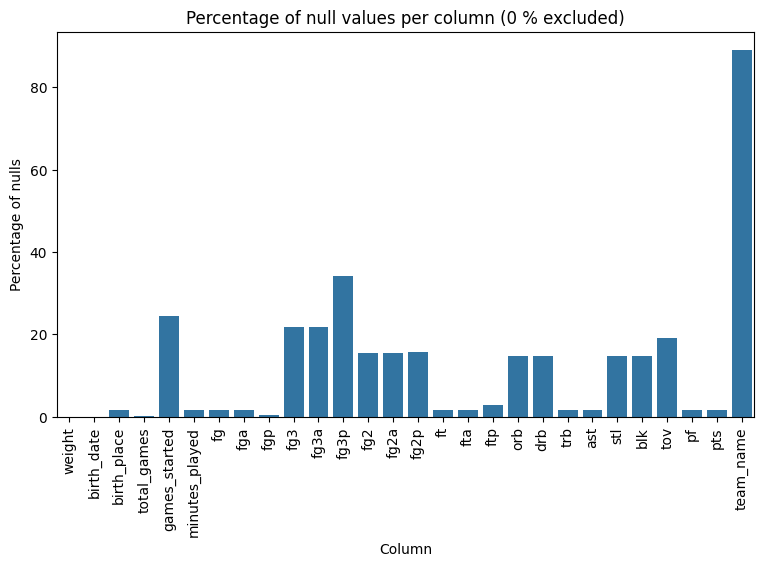

In [17]:
# don't visualize all columns that are zero as there is no need to visualise them
df_null_plot = df_merged.loc[:,df_merged.isnull().sum() != 0]
null_per_column = df_null_plot.isnull().sum()
percentage_per_column = null_per_column/len(df_null_plot)*100
percentage_per_column.apply(lambda x: f"{np.round(x,2)} %")

plt.figure(figsize=(9,5))
ax = sns.barplot(percentage_per_column)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Percentage of nulls")
ax.set_xlabel("Column")
ax.set_title("Percentage of null values per column (0 % excluded)")


Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

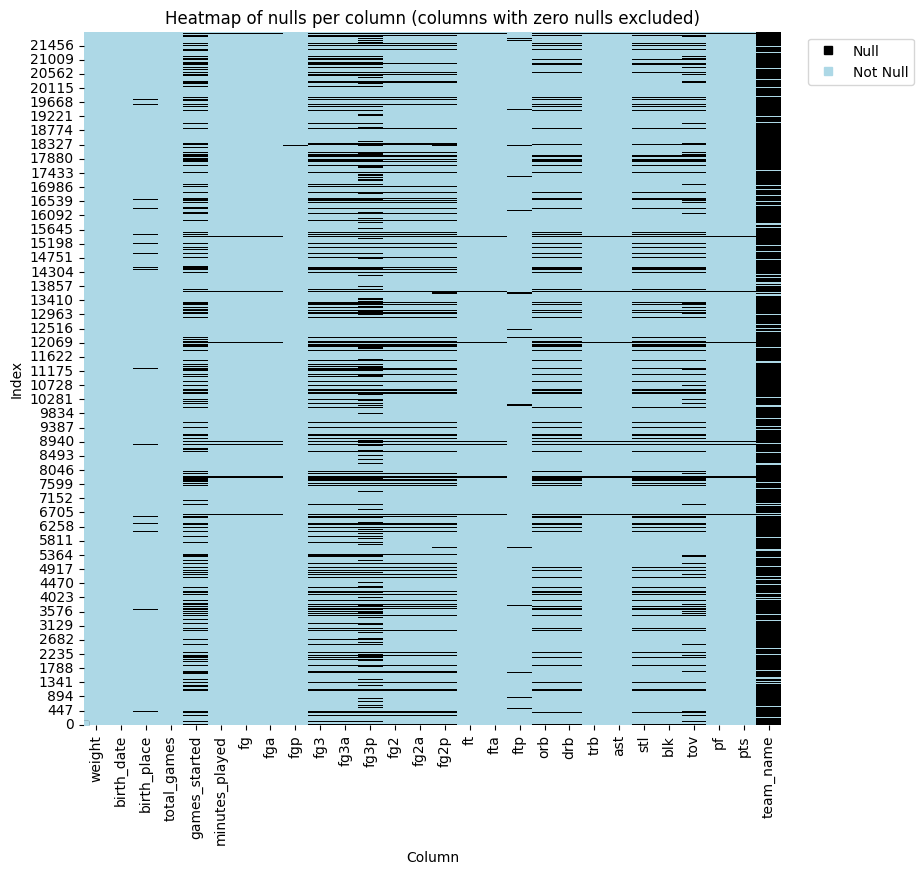

In [18]:
colors = ["lightblue", "black"]
plt.figure(figsize=(9, 9))
ax = sns.heatmap(
    df_null_plot.isnull(),
    cmap=colors,
    cbar=False
)

plt.plot([0], label = "Null", color = colors[1], marker = "s", linestyle = "")
plt.plot([0], label= "Not Null", color = colors[0], marker = "s", linestyle = "")
legend = plt.legend( bbox_to_anchor=(1.2, 1))
ax.invert_yaxis()
ax.set_ylabel("Index")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

#### Handling Nulls in team_name

Missing value in the "team_name" means that the player currently has no team, since we chose "team_name" to represent only the current team of the player. Most cases can be explained by the "retired" column. So if the player is retired, their team will be assigned to "Retired". However, there are cases, in which a player is not retired but has no entry for the "current_team_id", so the missing values won't be handled by the default method.

As mentioned above, it is impossible to track, to which team each player belonged in which seasons, and for some cases, the "teams" column contains just an empty list. Judging by the "text" column that contains a short biography of each player, the players indeed played for some of the teams that are in the data, so assigning "Other" would be technically incorrect. Therefore, we decided to fill the other Nulls, of which there are relatively few, with "No Information".

There are no missing values in the "retired" column, so all cases must be covered accurately.

In [19]:
#fill the missing team names for the retired players
df_merged.loc[df_merged["retired"], "team_name"] = "Retired"
print(f"Number of players that have no team and are not retired: {len(df_merged.loc[df_merged["team_name"].isna()])}")

#fill other missing team names
df_merged["team_name"].fillna("No Information", inplace = True)

Number of players that have no team and are not retired: 133


##### Handling the missing values in players' personal information
From the plot above we see that there are some entries where personal information of players such as weight, birth_date and birth_place are missing. 
We will handle them separately. 
- **weight**: there are no missing values in the "height" column, so we fill the missing values here with the average weight of the players' of the same height. For all different height values the corresponsing average weight values could be computed.
- **birth_date**: there is only one player with a missing birth_date, so we will fill his birth date manually.
- **birth_place**: this attribute is hard to fill accurately since it is a very specific piece of categorical data. There are also 331 misisng values, so it is not feasible to input them manually. Since we want to use the birth_place data for the visualization we would like it to be as accurate as possible. We noticed a pattern in the biographical "text" column that the first mention of a state is normally either a birth state or a high school state, where their basketball career begins. We will therefore fill the columns based on the first mentioned USA state. 

In [20]:
#create a dictionary {height: average weight}
height_to_weight = df_merged[["height_inches", "weight"]].groupby('height_inches')['weight'].mean().to_dict()
#fill the missing values in the weight column with the computed averages
df_merged['weight'] = df_merged['weight'].fillna(df_merged['height_inches'].map(height_to_weight))

In [21]:
#fill the only missing birth_date manually
df_merged["birth_date"].fillna("1932-05-10", inplace = True)

In [22]:
df_merged.loc[df_merged["birth_place"].isna()]["text"]

67       Forest Edward "Frosty" Able (born July 27, 193...
80       Charles R. "Bud" Acton (born January 11, 1942 ...
216      Gary R. Alcorn (October 8, 1936 – November 29,...
217      Gary R. Alcorn (October 8, 1936 – November 29,...
267      Robert J. Allen (born July 17, 1946) is an Ame...
                               ...                        
21779    Wayne Yates (born November 7, 1937) is a retir...
21854    David A. Zeller (born June 8, 1939) is a forme...
21855    Gary Lynn Zeller (November 20, 1947 – February...
21856    Gary Lynn Zeller (November 20, 1947 – February...
21883    William Charles Zopf (born June 7, 1948) is a ...
Name: text, Length: 331, dtype: object

#### Handling the missing values in performance statistics

#### Final check

Plot the same heatmap as above to see the impact of the Null-handling methods.

Text(0.5, 1.0, 'Heatmap of nulls per column (columns with zero nulls excluded)')

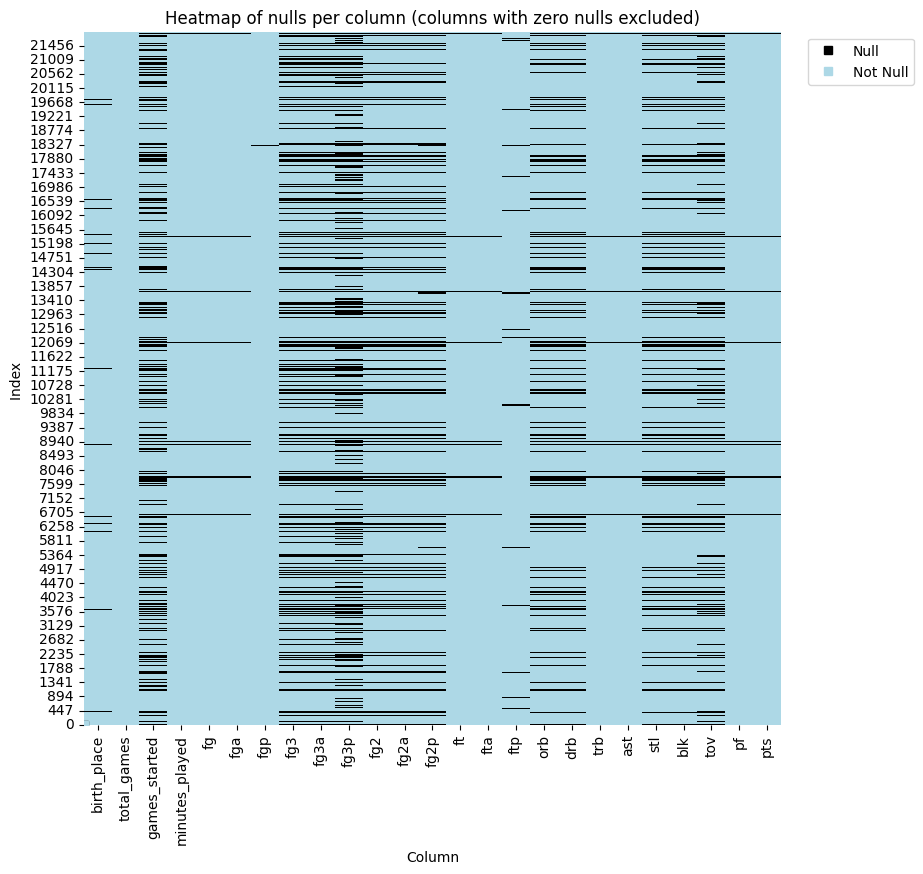

In [25]:
df_null_plot = df_merged.loc[:,df_merged.isnull().sum() != 0]
colors = ["lightblue", "black"]
plt.figure(figsize=(9, 9))
ax = sns.heatmap(
    df_null_plot.isnull(),
    cmap=colors,
    cbar=False
)

plt.plot([0], label = "Null", color = colors[1], marker = "s", linestyle = "")
plt.plot([0], label= "Not Null", color = colors[0], marker = "s", linestyle = "")
legend = plt.legend( bbox_to_anchor=(1.2, 1))
ax.invert_yaxis()
ax.set_ylabel("Index ")
ax.set_xlabel("Column")
ax.set_title("Heatmap of nulls per column (columns with zero nulls excluded)")

## Creating grouped tables
Create two new tables: one that groups rows based on player_id, another that groups rows based on team_id.

In [24]:
df_player_id = df_merged.groupby(["player_id", "name"]).agg({'A' : ['sum', 'min'],
                                                             'B' : ['min', 'max']})).reset_index()
df_player_id.head()

SyntaxError: unmatched ')' (3780963168.py, line 2)

In [ ]:
df_player_id = df_merged.groupby(["player_id", "name"]).sum().reset_index()
df_player_id.head()

## Data visualisation
Visualize the data (twice). Every submitted notebook should contain at least two visualizations using at least two different Python visualization libraries. One visualization for each of the new tables (aggregated players or aggregated teams). A list of the most wide-spread Python visualization libraries can be found in this article. You must concisely describe and explain each visualization and your decisions in a Markdown field. You will not receive the points for this task if you did not add a description/explanation. 

### @Sasha
Ich habe folgende Vorschläge, wie wir mit dem droppen umgehen könnten:
1. Wir droppen einfach alle Columns bei welchen die Prozentzahl über einer gewissen thresshold ist
2. Wir schauen uns an ob man evtl. den Durchschnitt für Spieler für manche Statisiken berechnen kann. Ich stelle mir das so vor, dass wenn z.B. 80 % der Werte für einen Spieler vorhanden sind, dass wir dann für die restlichen 20% den Durchschnitt berechnen.


# Sasha

In [ ]:
birth_places = df_merged["birth_place"].unique()

In [ ]:
df_merged["birth_states"] = df_merged["birth_place"].str.split(',', expand=True)[1]
df_merged['birth_states'] = df_merged['birth_states'].apply(lambda x: str(x).replace(u'\xa0', u''))


In [ ]:
all_states = pd.Series(df_merged["birth_states"].unique())

In [ ]:
US_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
    'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
    'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
    'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
    'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
    'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
    'West Virginia', 'Wisconsin', 'Wyoming'
]

US_state_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

In [ ]:
df_merged_US = df_merged.loc[df_merged["birth_states"].isin(US_states)]
df_merged_US['state_code'] = df_merged_US['birth_states'].map(US_state_to_code)

In [ ]:
np.setdiff1d(US_states, all_states[pd.Series(all_states).isin(US_states)].unique())

In [ ]:
df_merged_US_map = df_merged_US[["birth_states","state_code", "player_id"]].groupby(["state_code", "birth_states"]).count().reset_index()

In [ ]:
# add Vermont to the table for completeness
df_merged_US_map = pd.concat([df_merged_US_map, pd.DataFrame([{"state_code":"VT", "birth_states":"Vermont","player_id":0}])], ignore_index=True)

In [ ]:
fig=px.choropleth(df_merged_US_map,locations="state_code", 
    locationmode="USA-states", 
    scope="usa",
    color="player_id",
    color_continuous_scale = "Blues",
    hover_name = "birth_states")

fig.update_layout(geo = dict(showlakes=False))

fig.add_scattergeo(
    locations=df_merged_US_map['state_code'],
    locationmode='USA-states',
    text=df_merged_US_map['state_code'],
    mode='text',
    hoverinfo="skip")

fig.update_layout(
    title={'text':'Number of NBA players born in each US state',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})


## Saving the results
Save the resulting tables (the cleaned player_data_per_36_min and the two new aggregated tables) as CSV. To be sure that the data is correctly saved, you can load it again. You will have to work with these tables for the second exercise.